# Project discription

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

##  Initialization

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [2]:
pip install category_encoders

     |████████████████████████████████| 69 kB 1.7 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [3]:
import category_encoders as ce

In [4]:
from category_encoders import TargetEncoder

### Open the files and look into the data

In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [6]:
print(phone.info())
print(phone.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


In [7]:
print(personal.info())
print(personal.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No


In [8]:
print(internet.info())
print(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes 

In [9]:
print(contract.info())
print(contract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-

## Data preparation

### Data preprocessing

In [10]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [11]:
def end(x):
    if x == 'No':
        return 0
    else:
        return 1

contract['end'] = contract['EndDate'].apply(end)

print(contract)

      customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes           Electronic check           29.85        29.85   
1        

In [12]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')
end_date = '2020-02-01'
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = end_date
contract['EndDate'] = contract['EndDate'].astype('datetime64')
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,end
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,1


In [13]:
contract['days'] = contract['EndDate'] - contract['BeginDate']
contract['days'] =contract['days'].dt.days

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors = 'coerce')
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,end,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,123


In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   end               7043 non-null   int64         
 9   days              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


### EDA

<AxesSubplot:xlabel='days', ylabel='MonthlyCharges'>

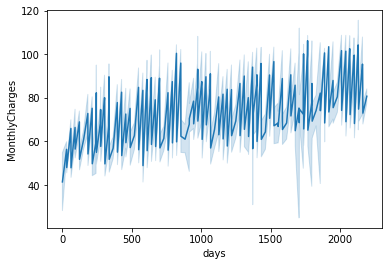

In [15]:
sns.lineplot(x='days', y='MonthlyCharges', data=contract)

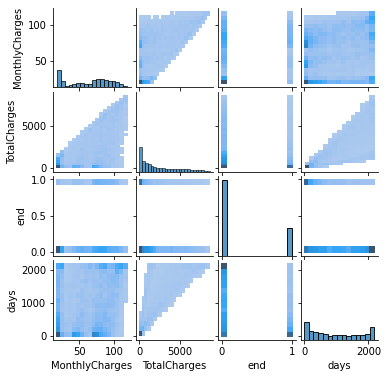

In [16]:
g = sns.pairplot(contract, kind='hist')
g.fig.set_size_inches(5, 5)

In [17]:
contract.describe()

,MonthlyCharges,TotalCharges,end,days
count,7043.000000,7032.000000,7043.000000,7043.000000
mean,64.761692,2283.300441,0.265370,985.996166
std,30.090047,2266.771362,0.441561,747.587844
min,18.250000,18.800000,0.000000,0.000000
25%,35.500000,401.450000,0.000000,273.000000
50%,70.350000,1397.475000,0.000000,883.000000
75%,89.850000,3794.737500,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


<AxesSubplot:xlabel='end', ylabel='MonthlyCharges'>

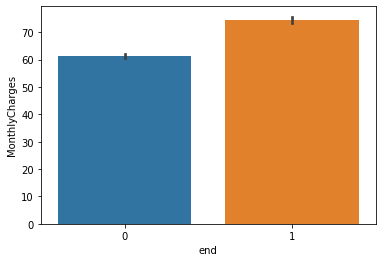

In [18]:
sns.barplot(x='end', y='MonthlyCharges', data=contract)

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

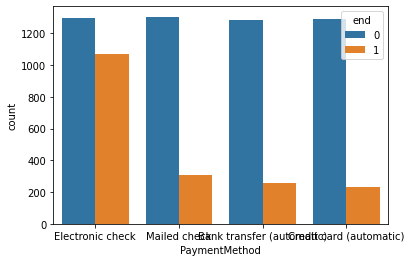

In [19]:
sns.countplot(x='PaymentMethod', hue='end', data=contract)

<AxesSubplot:xlabel='end', ylabel='count'>

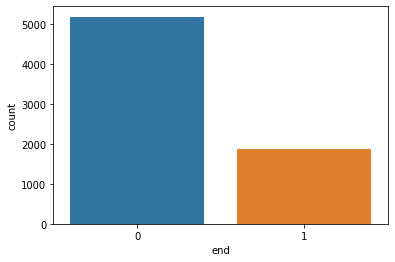

In [20]:
sns.countplot(x='end', data=contract)

The target is imbalanced. We can take it into account at splitting.

### Features and target preparation

In [21]:
df = contract.merge(personal, on='customerID',how='left')

In [22]:
df = df.merge(internet, on='customerID',how='left')

In [23]:
df = df.merge(phone, on='customerID',how='left')

In [24]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,end,days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,730,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2191,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,123,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   end               7043 non-null   int64         
 9   days              7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

In [26]:
df = df.fillna('NotApplicable')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   end               7043 non-null   int64         
 9   days              7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

In [27]:
#def internet(x):
 #   if x=='NotApplicable':
  #      return 0
   # else:
    #    return 1
#
#df['internet'] = df['InternetService'].apply(internet)

#df.sample(10)

In [28]:
df=df.drop(['customerID','BeginDate','EndDate'],axis=1)

In [29]:
df=df.drop('TotalCharges',axis=1)

In [30]:
df

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,end,days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NotApplicable
1,One year,No,Mailed check,56.95,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NotApplicable
4,Month-to-month,Yes,Electronic check,70.70,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,0,730,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,One year,Yes,Credit card (automatic),103.20,0,2191,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,Month-to-month,Yes,Electronic check,29.60,0,337,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NotApplicable
7041,Month-to-month,Yes,Mailed check,74.40,1,123,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [31]:
def ohe (df, column, name):
    coded = pd.get_dummies(df[column], prefix=name, drop_first=True)
    df = df.drop(column, axis=1)
    return df.join(coded)

In [32]:
df = ohe(df, 'gender', 'gender')
df = ohe(df, 'SeniorCitizen', 'SC')


In [33]:
df = ohe(df, 'PaperlessBilling', 'PB')
df = ohe(df, 'Partner', 'Partner')
df = ohe(df, 'Dependents', 'Dependents')
df

,Type,PaymentMethod,MonthlyCharges,end,days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender_Male,SC_1,PB_Yes,Partner_Yes,Dependents_Yes
0,Month-to-month,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,NotApplicable,0,0,1,1,0
1,One year,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,No,1,0,0,0,0
2,Month-to-month,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,No,1,0,1,0,0
3,One year,Bank transfer (automatic),42.30,0,1371,DSL,Yes,No,Yes,Yes,No,No,NotApplicable,1,0,0,0,0
4,Month-to-month,Electronic check,70.70,1,61,Fiber optic,No,No,No,No,No,No,No,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Mailed check,84.80,0,730,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,1,0,1,1,1
7039,One year,Credit card (automatic),103.20,0,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,0,1,1,1
7040,Month-to-month,Electronic check,29.60,0,337,DSL,Yes,No,No,No,No,No,NotApplicable,0,0,1,1,1
7041,Month-to-month,Mailed check,74.40,1,123,Fiber optic,No,No,No,No,No,No,Yes,1,1,1,1,0


In [34]:
def encode_type(x):
    if x == 'Month-to-month' :
        res = 0
    elif x == 'One year' :
        res = 1
    elif x == 'Two year' :
        res = 2
    return res
df['Type'] = df['Type'].apply(encode_type).astype('int8')
df

,Type,PaymentMethod,MonthlyCharges,end,days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender_Male,SC_1,PB_Yes,Partner_Yes,Dependents_Yes
0,0,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,NotApplicable,0,0,1,1,0
1,1,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,No,1,0,0,0,0
2,0,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,No,1,0,1,0,0
3,1,Bank transfer (automatic),42.30,0,1371,DSL,Yes,No,Yes,Yes,No,No,NotApplicable,1,0,0,0,0
4,0,Electronic check,70.70,1,61,Fiber optic,No,No,No,No,No,No,No,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,Mailed check,84.80,0,730,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,1,0,1,1,1
7039,1,Credit card (automatic),103.20,0,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,0,1,1,1
7040,0,Electronic check,29.60,0,337,DSL,Yes,No,No,No,No,No,NotApplicable,0,0,1,1,1
7041,0,Mailed check,74.40,1,123,Fiber optic,No,No,No,No,No,No,Yes,1,1,1,1,0


In [35]:
df = ohe(df, 'MultipleLines', 'ML')
df

,Type,PaymentMethod,MonthlyCharges,end,days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender_Male,SC_1,PB_Yes,Partner_Yes,Dependents_Yes,ML_NotApplicable,ML_Yes
0,0,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,0,0,1,1,0,1,0
1,1,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,1,0,0,0,0,0,0
2,0,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,1,0,1,0,0,0,0
3,1,Bank transfer (automatic),42.30,0,1371,DSL,Yes,No,Yes,Yes,No,No,1,0,0,0,0,1,0
4,0,Electronic check,70.70,1,61,Fiber optic,No,No,No,No,No,No,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,Mailed check,84.80,0,730,DSL,Yes,No,Yes,Yes,Yes,Yes,1,0,1,1,1,0,1
7039,1,Credit card (automatic),103.20,0,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,0,1,1,1,0,1
7040,0,Electronic check,29.60,0,337,DSL,Yes,No,No,No,No,No,0,0,1,1,1,1,0
7041,0,Mailed check,74.40,1,123,Fiber optic,No,No,No,No,No,No,1,1,1,1,0,0,1


In [36]:
df = df.replace(['NotApplicable'],'No')
df

,Type,PaymentMethod,MonthlyCharges,end,days,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender_Male,SC_1,PB_Yes,Partner_Yes,Dependents_Yes,ML_NotApplicable,ML_Yes
0,0,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,0,0,1,1,0,1,0
1,1,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,1,0,0,0,0,0,0
2,0,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,1,0,1,0,0,0,0
3,1,Bank transfer (automatic),42.30,0,1371,DSL,Yes,No,Yes,Yes,No,No,1,0,0,0,0,1,0
4,0,Electronic check,70.70,1,61,Fiber optic,No,No,No,No,No,No,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,Mailed check,84.80,0,730,DSL,Yes,No,Yes,Yes,Yes,Yes,1,0,1,1,1,0,1
7039,1,Credit card (automatic),103.20,0,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,0,1,1,1,0,1
7040,0,Electronic check,29.60,0,337,DSL,Yes,No,No,No,No,No,0,0,1,1,1,1,0
7041,0,Mailed check,74.40,1,123,Fiber optic,No,No,No,No,No,No,1,1,1,1,0,0,1


In [37]:
df = ohe(df, 'InternetService', 'InS')
df = ohe(df, 'OnlineSecurity', 'OnS')
df = ohe(df, 'OnlineBackup', 'OnB')
df = ohe(df, 'DeviceProtection', 'DP')
df = ohe(df, 'TechSupport', 'TS')
df = ohe(df, 'StreamingTV', 'STV')
df = ohe(df, 'StreamingMovies', 'SM')
df

,Type,PaymentMethod,MonthlyCharges,end,days,gender_Male,SC_1,PB_Yes,Partner_Yes,Dependents_Yes,ML_NotApplicable,ML_Yes,InS_Fiber optic,InS_No,OnS_Yes,OnB_Yes,DP_Yes,TS_Yes,STV_Yes,SM_Yes
0,0,Electronic check,29.85,0,31,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0
1,1,Mailed check,56.95,0,1036,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,0,Mailed check,53.85,1,61,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0
3,1,Bank transfer (automatic),42.30,0,1371,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0
4,0,Electronic check,70.70,1,61,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,Mailed check,84.80,0,730,1,0,1,1,1,0,1,0,0,1,0,1,1,1,1
7039,1,Credit card (automatic),103.20,0,2191,0,0,1,1,1,0,1,1,0,0,1,1,0,1,1
7040,0,Electronic check,29.60,0,337,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0
7041,0,Mailed check,74.40,1,123,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0


In [38]:
encoder = TargetEncoder()
df['PaymentMethod'] = encoder.fit_transform(df['PaymentMethod'], df['MonthlyCharges'])
df.sample(10)

/opt/conda/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/opt/conda/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,Type,PaymentMethod,MonthlyCharges,end,days,gender_Male,SC_1,PB_Yes,Partner_Yes,Dependents_Yes,ML_NotApplicable,ML_Yes,InS_Fiber optic,InS_No,OnS_Yes,OnB_Yes,DP_Yes,TS_Yes,STV_Yes,SM_Yes
2690,0,66.512385,80.45,1,244,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0
3588,0,66.512385,69.05,0,276,1,0,1,1,0,0,1,0,0,0,1,1,0,0,1
6699,2,43.917060,20.50,0,1645,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
559,0,76.255814,49.30,0,31,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
925,0,67.192649,76.30,0,975,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1
6695,2,43.917060,71.10,0,2163,0,0,0,1,1,0,1,0,0,1,1,1,1,0,0
702,0,76.255814,84.90,0,883,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1
3065,0,43.917060,45.80,0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2984,1,43.917060,26.00,0,792,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
6278,2,67.192649,104.30,0,2132,0,0,1,1,0,0,1,1,0,0,0,1,1,1,1


All categorical values were encoded using target encoding and OHE. Column "InS_No" takes into account whether the user has internet or not.

In [39]:
X = df.drop('end', axis=1)
y = df['end']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [41]:
##ss = StandardScaler()
##ss.fit(X_train)
#X_train = pd.DataFrame(ss.transform(X_train), columns = X_train.columns)
#3X_test = pd.DataFrame(ss.transform(X_test), columns = X_test.columns, index=X_test.index)

## Modelling

### Baseline model

In [42]:
pred_bm = [0] * y.shape[0]
roc_auc_bm = roc_auc_score(y.values, pred_bm)
print(f"roc_auc: {roc_auc_bm:.3f}")
accuracy_bm = accuracy_score(y.values, pred_bm)
print(f"accuracy: {accuracy_bm:.3f}")

roc_auc: 0.500
accuracy: 0.735


### Logistic Regression

In [43]:
# Logistic regression
model_lr = LogisticRegression(C=0.5)
roc_auc_lr = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"roc_auc of Logistic Regression model: {roc_auc_lr:.3f}")
accuracy_lr = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f"accuracy of Logistic Regression model: {accuracy_lr:.3f}")

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

roc_auc of Logistic Regression model: 0.844


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

accuracy of Logistic Regression model: 0.803


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random forest

In [44]:
param_grid = {'n_estimators': [300],
              'max_depth': [5, 7, 9],
              'max_features': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [2, 4, 6]
             }

model_rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator = model_rf,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2,
                           scoring = 'roc_auc')
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END m

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [3, 5, 7],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [300]},
             scoring='roc_auc', verbose=2)

In [45]:
print('model params: ', grid_search_rf.best_params_)
print(f"roc_auc: {grid_search_rf.best_score_:.3f}")

model params:  {'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
roc_auc: 0.864


### CatBoost Model

In [46]:
param_grid = {'iterations': [2000],
              'learning_rate': [0.1,0.02],
              'depth': [3,7,10]}

model_cbm = CatBoostClassifier()
grid_search_cbm = GridSearchCV(estimator = model_cbm,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2,
                           scoring = 'roc_auc')
grid_search_cbm.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 0.6296966	total: 47.3ms	remaining: 1m 34s
1:	learn: 0.5830917	total: 48.2ms	remaining: 48.1s
2:	learn: 0.5542679	total: 49ms	remaining: 32.6s
3:	learn: 0.5315138	total: 49.7ms	remaining: 24.8s
4:	learn: 0.5098793	total: 50.3ms	remaining: 20.1s
5:	learn: 0.4887942	total: 51.1ms	remaining: 17s
6:	learn: 0.4766701	total: 51.8ms	remaining: 14.8s
7:	learn: 0.4647430	total: 52.6ms	remaining: 13.1s
8:	learn: 0.4534508	total: 53.4ms	remaining: 11.8s
9:	learn: 0.4458936	total: 54.1ms	remaining: 10.8s
10:	learn: 0.4394801	total: 54.9ms	remaining: 9.92s
11:	learn: 0.4348073	total: 55.6ms	remaining: 9.22s
12:	learn: 0.4309912	total: 56.4ms	remaining: 8.62s
13:	learn: 0.4265728	total: 57.2ms	remaining: 8.12s
14:	learn: 0.4204720	total: 58.1ms	remaining: 7.69s
15:	learn: 0.4165909	total: 58.9ms	remaining: 7.3s
16:	learn: 0.4117695	total: 59.6ms	remaining: 6.95s
17:	learn: 0.4084093	total: 60.4ms	remaining: 6.66s
18:	learn: 0.40608

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7ff9ca8845e0>,
             n_jobs=-1,
             param_grid={'depth': [3, 7, 10], 'iterations': [2000],
                         'learning_rate': [0.1, 0.02]},
             scoring='roc_auc', verbose=2)

In [47]:
print('model params: ', grid_search_cbm.best_params_)
print(f"roc_auc: {grid_search_cbm.best_score_:.3f}")

model params:  {'depth': 3, 'iterations': 2000, 'learning_rate': 0.1}
roc_auc: 0.926


CatBoost model showed the best AUC-ROC results at cross-validation.

## Check the quality of the model using the test set

In [48]:
roc_auc_cbm = roc_auc_score(y_test, grid_search_cbm.predict_proba(X_test)[:, 1])
print(f"roc_auc of CatBoost model on test set: {roc_auc_cbm:.3f}")

roc_auc of CatBoost model on test set: 0.929


In [49]:
accuracy_cbm = accuracy_score(y_test, grid_search_cbm.predict(X_test))
print(f"accuracy of CatBoost model on test set: {accuracy_cbm:.3f}")

accuracy of CatBoost model on test set: 0.884


## Conclusions

1. All the data was merged.
2. Categorical values were encoded, all values were scaled.
3. CatBoost model showed the best value of AUC-ROC metric and accuracy. 

# Solution Report

**The goal of the project was to forecast the churn of clients.**

1. The main steps of the plan were: data preparation, EDA, tunning and training of several models, and checking the quality of the chosen model on the test set. 


2. All the steps were performed according to plan. During data preparation, it was decided not to perform data scaling due to the usage of cross-validation.


3. The challenging part was to encode all the categorical features in an accurate way while keeping the number of features reasonable. Target encoding and OHE were used. According to our data, not all users used internet or phone services, so we made sure to mark them for the models. 


4. So, first, we assigned all the columns with the according datatype. 

    Then we calculated time that client used services. 

    Composed our target column based on whether the customer had ‘No’ in the EndDate column.
    Noted the imbalanced target to take it into account later.
    
    All the data have been merged based on the users’ ids. Since some clients didn’t use phone or internet services, we filled the missing values and made sure to keep information about that fact while encoding. 
    
    All the dates were dropped to avoid target leakage, only the duration of the usage of the services was left. Columns with customer ids and total charges were dropped. 
    
    All the categorical values were encoded using OHE and target encoding.
    
    The data was split into train and test. A stratified split was used as we're dealing with imbalanced data. 
    
    For the baseline, we’ve chosen a constant model, where all the clients are still with us.
    AUC-ROC of the baseline model was 0.5. Accuracy: 0.735.
    
    The first model we tried was a logistic regression with cross-validation, AUC-ROC of the logistic regression model on the train set was 0.844. 
    
    The second model was Random Forest. Where we’ve used GridSearch cross-validation for the parameters tuning. The model with the best parameters showed an AUC-ROC of 0.864 on the training set.
    
    The last model was CatBoost Model with GridSearch cross-validation for the parameters tuning.
    The model with the best parameters showed an AUC-ROC of 0.926 on the training set.
    
    
5. The CatBoost model was chosen as the best based on the AUC-ROC performance.
    
    **The final AUC-ROC of the final CatBoost model on the test set was 0.929. Accuracy – 0.884.**





